In [1]:
from brian2 import *
%matplotlib inline
%matplotlib inline 
rcParams['figure.figsize'] = 20, 15

In [2]:
data_file = ".\\Data\\iris_data_012.txt"
data_x = np.loadtxt(data_file, delimiter=",", usecols=range(0,4),
    dtype=np.float64)
data_y = np.loadtxt(data_file, delimiter=",", usecols=[4],
    dtype=np.int)

In [3]:
#Pre trained SOM wegiht matrix // This has being trained in a iris data set with 4 attributes
weights=np.load('weights.npy')
n,m,k=weights.shape

In [4]:
#Number of attributes of the dataset
N_vec=k
#Number of neurons
M_mat=n*m
#Sample that we are going to check 
sample=np.array([5,3.5,1.4,9])
#Arranging the weight values to use as synapses
synapseWeights = []
for p in range(k):
    for i in range(n):
        for j in range(m):
            synapseWeights.append(weights[i][j][p])
        


In [5]:
## Modyfing the sample to spike times
spike_times=np.array(sample)
spike_times/=10
spike_times=spike_times*second
spike_indices=np.array(range(N_vec))
spike_times,spike_indices


(array([0.5 , 0.35, 0.14, 0.9 ]) * second, array([0, 1, 2, 3]))

In [6]:
## Leaky intergrate fire model
tau = 1000000*msecond
El = 0*mV
v_reset = -80*mV
eqs = '''
dV/dt = ((El - V) + I)/tau : volt
I : volt
'''

s_h = '''
mag : 1
'''
# calculation of square of diffn
s_h_on_pre = '''
V_post += ((mag-t/(100*msecond))**2)*volt
'''

In [7]:
## Neuron group related to the input 
G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)
## Neuron group related to the each neuron in SOM 
G_post = NeuronGroup(M_mat, model=eqs, threshold='V>100000000*mV', reset="V=v_reset",  
                      method='euler')
#Initialization of values for each neuron
G_post.V = (El + 0.0*mV) * ones(M_mat)
G_post.I = 0 *volt

#Setting the synaptic connections between two neuron groups
S_pre_post = Synapses(G_pre, G_post, s_h, on_pre=s_h_on_pre, method='euler')
S_pre_post.connect()
#Initializing synaptic weights as SOM weight values
S_pre_post.mag = np.around(synapseWeights,decimals=2)
##monitors to monitor variables
SpM_post = SpikeMonitor(G_post, variables=['V'])
StM_post = StateMonitor(G_post, True, record=True)
StM_post_syn = StateMonitor(S_pre_post, True, record=True)


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [8]:
#Build the network
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)
complex_net.add(S_pre_post)
complex_net.add(SpM_post)
complex_net.add(StM_post)
complex_net.add(StM_post_syn)
complex_net.store('init')

In [9]:
## run the network
run_time = 2 * second
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst)

elapsed 3.6608169078826904


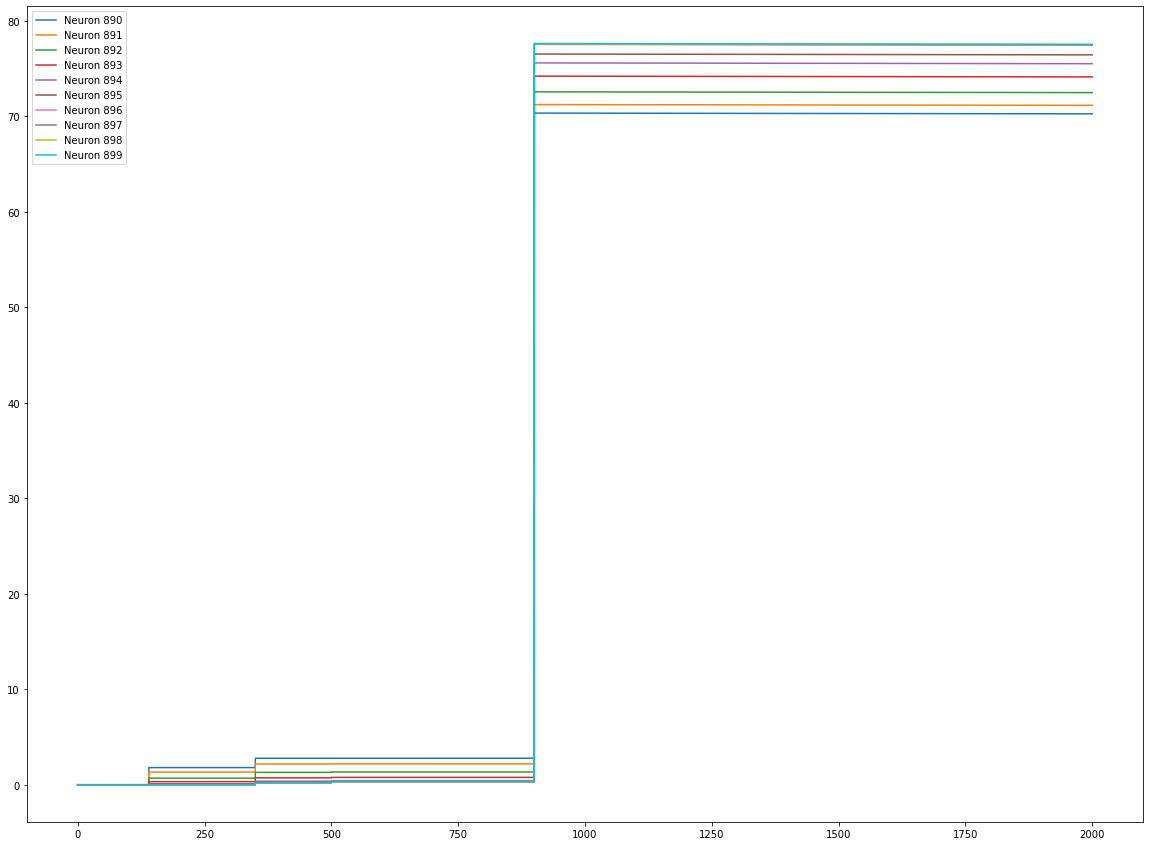

In [10]:
#Plot membrane potential of each post synaptic neuron
for i in range(890,900):
    plot(StM_post.t/ms, StM_post.V[i], label='Neuron '+str(i))
plt.legend()

In [11]:
# Find the neuron with the minimum membrane potential(i.e. the BMU for the given sample)
ind =int(np.argmin(G_post.V))
row,col=ind//n,ind%m
print("Row index -",row)
print("Col index -",col)
print("Final value -",min(G_post.V))

Row index - 29
Col index - 2
Final value - 64.16266483 V


In [12]:
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2) 

In [13]:
#Find the BMU using traditional Way
actual_i,actual_j=0,0
best = 1e20
for i in range(n):
    for j in range(m):
        cur = euc_dist(np.around(weights[i][j],decimals=2),sample)
        if(cur<best):
            actual_i,actual_j=i,j
            best=cur
print("Row index -",actual_i)
print("Col index -",actual_j)
print("Best value -",best**2)

Row index - 29
Col index - 2
Best value - 64.2419
